## Anomaly Detection using AutoEncoder

#### Detection of anomaly records in a dataset, using AutoEncoder dimensionality reduction & reconstruction 

##### Concept:
1.Autoencoder is basically a neural network which has two parts - Encoder and Decoder which in turn consist of a number of layers of neurons. <br><br>
**Encoder**
Encoder layers come first in the stack. The encoder takes the original input feature values, apply weights and activation function on them and pass (feed-forward) the output from one layer to another. The layers in the encoder are stacked in such a way that the number of neurons in each layer is lesser than it's previous layer from which it receives it's input. 
So the encoder fundamentally does a **dimension reduction** - reduce a big dimension (N number of features), to a smaller dimension (n number of derived features). This smaller number of n values, in a way represent the essence of the original data. But this would come with some information loss too.
<br><br>
**Decoder**
Decoder layers come after the encoder part. The decoder takes the reduced dimension values as input from the encoder, apply it's weights and activation and feed-forward the output from it's one layer to another. The layers in the decoder are stacked in such a way that the number of neurons in each layer is larger than it's previous layer from which it receives it's input. Also it's last layer (output layer) has the same number of neurons as the original input feature values (N). So, essentially the decoder does a **dimension reconstruction** of the input that the decoder reduced - take n small dimension values as input from the decoder and finally reconstructs N values (same dimension as the original input passed to the encoder). 

2.Thus the **encoder extracts and "juices out" the necessary essence from a input data point, and the decoder tries to reconstruct from the essence**, some corresponding value for each input value (Same number of features/dimension as the input record).

3.The **autoencoder training** is done in such a way that the final reconstructed vector of values should be as close as possible to the original vector of input values. For example, you can think of inputting the pixel values of a T-shirt image to the auto-encoder and it produces it's own set of pixels trying to create a duplicate of the original image, aiming to make it as close in resemblance to the original as possible. So it is a **self-supervised (a special kind of unsupervised training )**, in which you don't have user-defined labels/targets to compare and compute the loss. Instead, the loss computation compares the output with the input itself (input acts as the labels/targets).

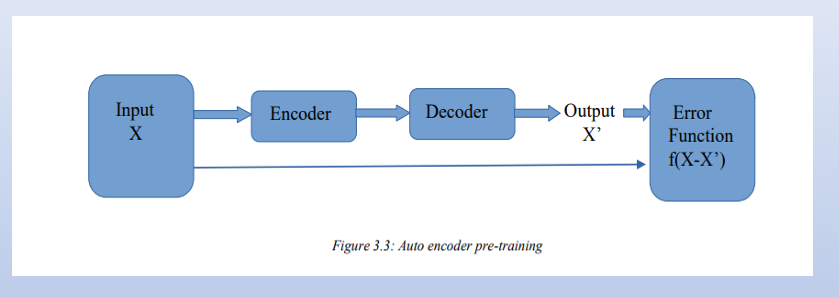

<br>Training is done by passing the train data as both the input and the target, till the AE is able to continuously learn the 
hidden features in the input data effectively and thereby minimize the reconstruction error. Gaussian noise was 
added to the input to avoid over-fitting. The error / loss of the autoencoder pre-training is calculated as the **Mean Square Error (MSE)**.

4.Basically, when the whole autoencoder is trained, <br>the **decoder is trained to extract** most of the latent features (low-dimensional essence) from the high-dimensional input data, <br>and the **encoder is trained to reconstruct** the original values back from the decoder's latent feature output, to the best of it's capacity.

5.When we compare the reconstructed data with the original data, we can compute the error (**reconstruction error**). The learning process is a minimisation function of reconstruction error.

6.If we **train a Autoencoder model on a good dataset** (without anomalies), the AE model learns the latent variance information from the good dataset. So when you apply the trained AE on another similar good test data, it can reduce and reconstruct it back very well with minimum reconstruction errors.

7.The above fact can be used to detect outliers/anomalies in any test data (bad dataset). Any outlier value in a feature will spoil the reduction and reconstruction that was learnt by the AE model trained a pure good data. This means, **with a bad dataset**, the model would "struggle" to properly reduce and reconstruct the original data points, thereby making **high reconstruction errors**.
So this "Autoencoder reconstruction error" is an effective metric to identify/detect anomalies out of huge number of records.



#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 


# To display the float values up to max 3 decimal points
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.float_format', '{:.3f}'.format)

## 1.Dataset Preparation

We are creating a dataset with 200,000 records and 25 numerical features. 
The main criterion is to have the 25 features highly linearly correlated with each other across the rows.
For each feature, the value should be some value in the range of min-(min+10) for some chosen min value.


I sought the help of ChatGPT to create the code to prepare such a dataset. 
ChatGPT did a pretty fair job, though not perfect in meeting my specifications.
Also I had to iterate in my prompts to expain what I wanted and it made some corrections in the code accordingly.

#### ChatGPT query:

**First prompt**:

I want a pandas dataframe with 25 features/columns. The conditions are as below.
1. The values of these features should be random numerical values. 
2. The values within each feature across rows should be constrained within a range (min, min+10) where each feature should select a particular min between 0 and 90.  
3. The features should be linearly correlated with each other, such that cummulative variance explained by 15 principal components should touch 92% and the variance delta added by each new principal component should be a curve with a curved elbow.
Can you please provide the code for creating such a dataframe ?

**Second Prompt**:

There is a slight change in the requirements. The variance explained by first PC should be around 75% and there after the delta variance should drop gradually, not in a steep way in such a way that it is not a straight line fall 


### ChatGPT response
The first principal component should explain around 75% of the variance.
The cumulative variance explained by the first 15 components should be close to 92%.
To achieve this, I will tweak the code by generating the data in such a way that the first few features are highly correlated, and the remaining ones add gradual variance. I'll also fine-tune the variance structure to ensure that the first 15 components explain 92% of the cumulative variance.


**Key Adjustments**:
**Base Feature Creation**: The first feature (or group of features) is designed to dominate the variance by having relatively small noise.
**Feature Noise Control**: Noise is added to the remaining features but in a controlled manner so that the variance drops gradually after the first component.
**Variance Tuning**: The variance of the added noise is controlled in such a way that the first principal component explains around 75% of the variance, and the cumulative variance explained by the first 15 components should approach 92%.


**Fine-Tuning**:
If the cumulative variance for the first 15 components doesn't reach 92% in the first attempt, you may need to iteratively adjust the noise levels for the subsequent features until you achieve the desired outcome.

Explained variance by first component: 0.72
Cumulative variance explained by the first 15 components: 0.96


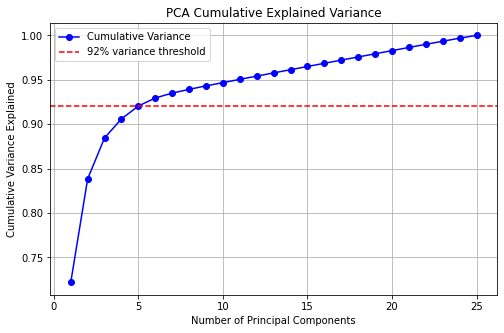

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25
0,13.000,10.000,51.000,52.000,55.000,49.000,13.000,47.000,58.000,89.000,...,39.000,68.000,79.000,31.000,45.097,37.182,70.000,25.535,40.000,36.000
1,13.000,10.000,61.000,62.000,65.000,59.000,13.000,57.000,68.000,99.000,...,39.000,78.000,89.000,31.000,50.000,45.000,80.000,31.000,50.000,36.000
2,13.000,10.000,61.000,62.000,65.000,59.000,13.000,57.000,68.000,89.000,...,39.000,76.577,80.889,31.000,50.000,45.000,70.000,31.000,50.000,36.000
3,13.000,10.000,61.000,58.127,62.668,59.000,13.000,57.000,59.356,89.000,...,39.000,68.000,79.000,31.000,50.000,45.000,70.000,31.000,50.000,36.000
4,13.000,10.000,51.000,52.000,55.000,49.000,13.000,47.000,58.000,89.000,...,29.000,68.000,79.000,21.000,40.000,35.000,70.000,21.000,40.000,26.000


In [2]:
# The below code was generated by ChatGPT

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Set parameters
num_features = 25  # Number of features/columns
num_rows = 200000    # Number of rows in the dataframe
target_variance_explained = 0.75  # Target variance explained by the first component

# Step 1: Create a strong first principal component (PC1) that dominates variance
# Generate base data for the dominant feature
base_data = np.random.rand(num_rows, 1) * 100  # This will be the main component

# Step 2: Add noise to create more features while keeping correlations strong
# For features with high correlation, add small noise to base_data
features = base_data + np.random.randn(num_rows, num_features) * 5  # Adjust noise

# Step 3: Ensure that each feature's values are constrained within a range [min, min+10]
for i in range(num_features):
    min_val = np.random.randint(0, 90)  # Randomly select a min value for each feature
    features[:, i] = np.clip(features[:, i], min_val, min_val + 10)

# Create the pandas dataframe from the features
df = pd.DataFrame(features, columns=[f"Feature_{i+1}" for i in range(num_features)])

# Step 4: Perform PCA to check the variance explained
pca = PCA(n_components=num_features)
pca.fit(df)

# Calculate explained variance and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Step 5: Adjust the noise in subsequent features to get cumulative variance close to 92%
# If necessary, iterate or fine-tune noise to achieve the 92% requirement

# Output the cumulative variance for the first principal components
print(f"Explained variance by first component: {explained_variance_ratio[0]:.2f}")
print(f"Cumulative variance explained by the first 15 components: {cumulative_variance[14]:.2f}")

# Step 6: Plot the explained variance (smooth elbow curve)
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_features + 1), cumulative_variance, marker='o', linestyle='-', color='b', label='Cumulative Variance')
plt.axhline(y=0.92, color='r', linestyle='--', label='92% variance threshold')
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.legend()
plt.show()

# Display the dataframe
df.head()


In [3]:
df.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25
count,200000.000,200000.000,200000.000,200000.000,200000.000,200000.000,200000.000,200000.000,200000.000,200000.000,...,200000.000,200000.000,200000.000,200000.000,200000.000,200000.000,200000.000,200000.000,200000.000,200000.000
mean,12.182,9.445,55.408,56.309,59.009,53.604,12.183,51.811,61.706,89.644,...,35.609,70.698,80.603,28.403,45.508,41.001,72.503,28.404,45.508,32.911
std,2.439,1.971,4.794,4.780,4.729,4.812,2.440,4.825,4.651,2.141,...,4.555,4.248,3.432,4.192,4.803,4.724,4.135,4.188,4.805,4.434
min,3.000,0.000,51.000,52.000,55.000,49.000,3.000,47.000,58.000,89.000,...,29.000,68.000,79.000,21.000,40.000,35.000,70.000,21.000,40.000,26.000
25%,13.000,10.000,51.000,52.000,55.000,49.000,13.000,47.000,58.000,89.000,...,29.000,68.000,79.000,25.002,40.000,35.000,70.000,25.021,40.000,26.000
50%,13.000,10.000,51.000,52.000,55.000,50.093,13.000,50.093,58.000,89.000,...,39.000,68.000,79.000,31.000,50.000,45.000,70.000,31.000,50.000,36.000
75%,13.000,10.000,61.000,62.000,65.000,59.000,13.000,57.000,68.000,89.000,...,39.000,74.987,79.000,31.000,50.000,45.000,75.018,31.000,50.000,36.000
max,13.000,10.000,61.000,62.000,65.000,59.000,13.000,57.000,68.000,99.000,...,39.000,78.000,89.000,31.000,50.000,45.000,80.000,31.000,50.000,36.000


## 2.Data Visualization

##### Creating a correlation heatmap is a great way to visualize the relationships between different features in your DataFrame. 

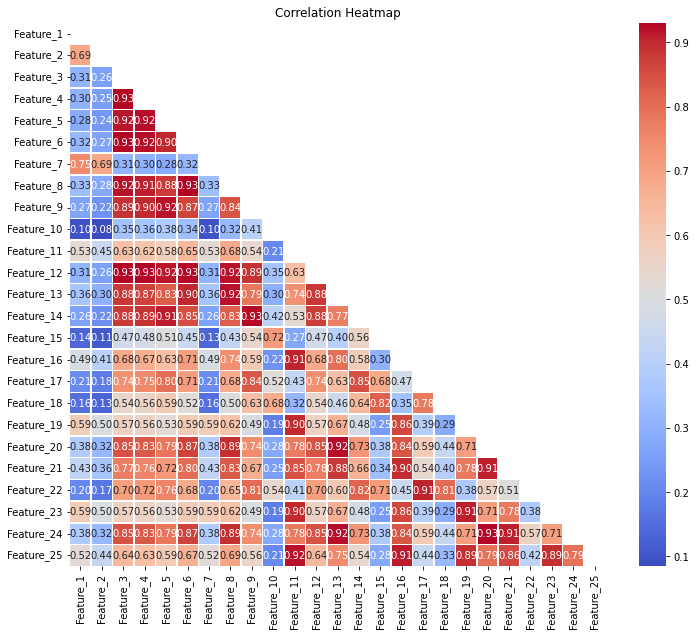

In [4]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))  # Adjust size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask = mask)
plt.title('Correlation Heatmap')
plt.show()

##### Observe the line plot of each feature and how they travel across the rows 

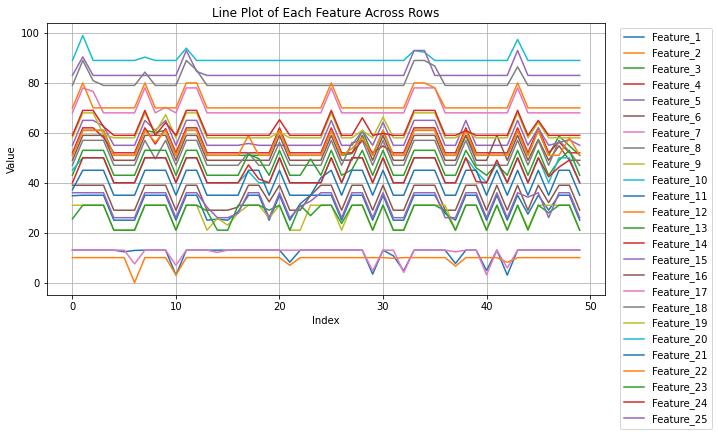

In [5]:
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

df_lim = df[0:50]
# Plot each feature in the DataFrame
for column in df_lim.columns:
    plt.plot(df_lim.index, df_lim[column], label=column)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot of Each Feature Across Rows')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))  # Adjust legend placement as needed
plt.grid(True)
plt.show()

We can see from above heatmap and line plots, that all the features appear to maintain a good positive correlation among each other. 

## 3.Prepare train, validation and test datasets

In [6]:
# Function to remove the outliers from a given data frame based on the Inter Quantile Range of the features.
def rem_outlier_df(df):

    Q1 = df.quantile(0.25)
    #print(Q1)
    Q3 = df.quantile(0.75)
    #print(Q3)
    
    IQR = Q3 - Q1

    ret_df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

    return ret_df

In [7]:
# Shuffle the rows of the data frame.
shuffled_df = df.sample(frac = 1)

# Scale down as per need
#shuffled_df = shuffled_df/100


In [8]:
# Split train, validation and test datasets from the original data frame.
train_df = shuffled_df.iloc[0:160000]
val_df = shuffled_df.iloc[160000:180000]
test_df = shuffled_df.iloc[180000:]

# Remove the outliers from the training df, val df and test_df to create a good datasets from each.
train_df = rem_outlier_df(train_df)
val_df = rem_outlier_df(val_df)
good_test_df = rem_outlier_df(test_df)

print(train_df.shape)
print(val_df.shape)
print(good_test_df.shape)

(97683, 25)
(12301, 25)
(12227, 25)


## 3. Hyper-parameter search & tuning for Autoencoder training

#### References:
#### Tuning Process by Andrew NG - https://www.youtube.com/watch?v=AXDByU3D1hA&t=22s
#### Using an Appropriate Scale by Andrew NG -  https://www.youtube.com/watch?v=cSoK_6Rkbfg


In [11]:
## Some helper functions.


# Function to compute the reconstruction error - Mean Absolute error.
  # Given the original df and the reconstructed df, we compute and return
    # the reconstruction error matrix (containing the error for each cell in the df)
    # the average loss row-wise. 
    # the average loss column-wise.

def df_mae_loss_score(originalDF, reconstDF):
    
    mae_err_matrix = np.abs((np.array(originalDF) - np.array(reconstDF)))
    #mae_err_matrix_rounded = np.around(mae_err_matrix, decimals=3)
    
    col_loss = np.sum(mae_err_matrix, axis = 0) / originalDF.shape[0]
    col_loss = pd.Series(data = col_loss, index = range(0,len(col_loss)))
    
    row_loss = np.sum(mae_err_matrix, axis = 1) / originalDF.shape[1]
    row_loss = pd.Series(data = row_loss, index = originalDF.index)
    
    return (row_loss, col_loss, mae_err_matrix)



# Function to return uniformly distributed learning rates between the range of low and high.
# Explained in the video  -  https://www.youtube.com/watch?v=cSoK_6Rkbfg
from builtins import round

def get_uniform_rand_lr(low, high, count):
    
    cnt = 0
    low = np.log10(low)
    high = np.log10(high)
    #print(low)
    #print(high)
    
    ret_lst = []
    
    while cnt < count: 
    
        r = np.random.uniform(low = low, high = high)
        #print(r)
        alpha = round(10 ** r, 7)
        ret_lst.append(alpha)
        #print(alpha)
        cnt += 1
        
    return ret_lst
    


### Function to plot learning curves of train and validation loss against the number of epochs completed.
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
   # plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([0, 50, 0, 0.6])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

### We will go with the following architecture of a symmetrical autoencoder. We will have two layers in each of the encoder and the decoder

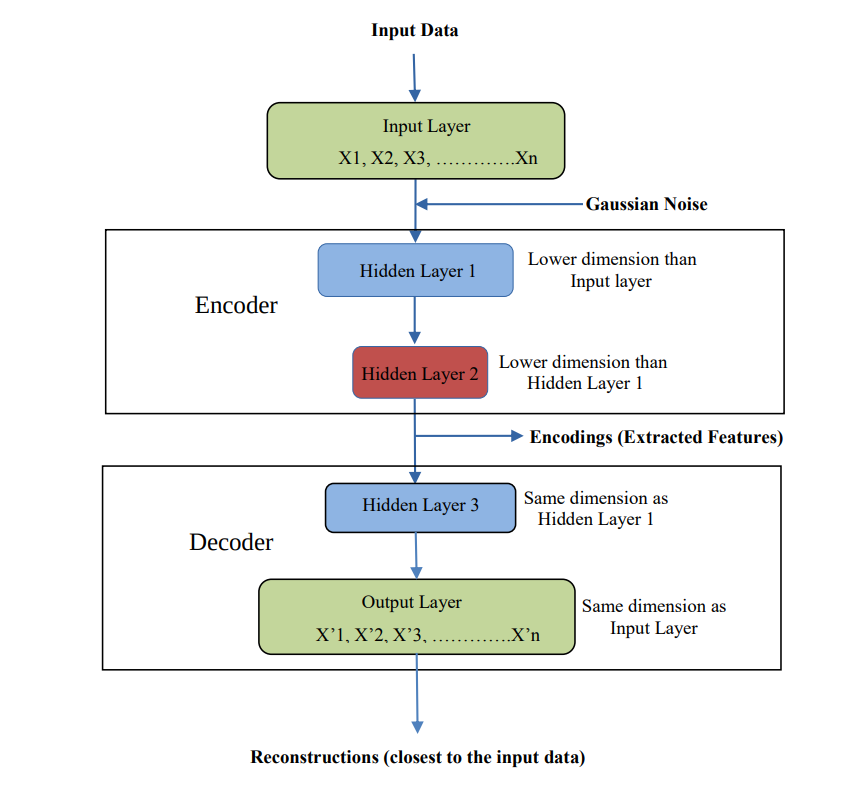

In [12]:
import time
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import gc


#os.environ['CUDA_VISIBLE_DEVICES'] = ''

# Input shape is set to the number of features (columns) in the original data frame.
inp_shape = 25

# A list to keep the created models to cleanup during the hyper-tuning process.
model_lst = []

tf.random.set_seed(42)


# Function to create, compile and return a Auto-encoder. This is called during hyper-param tuning.
#   Input - the sizes(number of neurons) of the different layers, learn rate, Gaussian noise and momentum etc.

def tuneModel_ord(layer_sizes, learn_rate, gnoise, act_func = 'relu', optim = 'Adam', momentum = 0.9):
    
    # Cleanup of the earlier model tried during hyper-tuning.
    if len(model_lst) > 0:
     ##   print('deleting old model')
        prev_model = model_lst.pop()
        del prev_model
        keras.backend.clear_session()
        gc.collect()
     #   ##tf.compat.v1.reset_default_graph()
    
    
        #tf.random.set_seed(42)
    
    
    if optim == 'SGD':
       optimiser = keras.optimizers.SGD(learning_rate = learn_rate)
    elif optim == 'Adam':
       optimiser = keras.optimizers.Adam(learning_rate = learn_rate, beta_1 = momentum)
    elif optim == 'RMSprop':
       optimiser = keras.optimizers.RMSprop(learning_rate = learn_rate, rho = momentum)
    
    #print(layer_sizes)
    #print(learn_rate)
    #print(gnoise)
    #print(act_func)
    #print(optim)
    #print()
    
    # Flattening layer - Encoder
    flat = keras.layers.Flatten(input_shape=[inp_shape])
    # Layer to introduce Gaussian noise to the inputs to prevent over-fitting - Encoder.
    gnl = keras.layers.GaussianNoise(gnoise)
    
    # First layer - Encoder
    dense1 = keras.layers.Dense(layer_sizes[0], activation = act_func)
    # Second layer - Encoder
    dense2 = keras.layers.Dense(layer_sizes[1], activation = act_func)
    
    # Third layer - Decoder
    dense3 = keras.layers.Dense(layer_sizes[0], activation = act_func)
    # Output layer - Decoder ( size same as the input length)
    dense4 = keras.layers.Dense(inp_shape)

    encoder = keras.models.Sequential([flat, gnl, dense1, dense2])
    decoder = keras.models.Sequential([dense3, dense4])

    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(loss = "mse", optimizer = optimiser)

    model_lst.append(autoencoder)
    return autoencoder

In [12]:
#lr_rand_lst = get_uniform_rand_lr(1e-4, 1e-1, 10)
#lr_rand_lst

### Random Search CV Tuning

In [13]:
# Scale the input values to be between 0 and 1.
# https://www.linkedin.com/advice/1/what-best-practices-scaling-features-neural-network-4myxf#:~:text=Scaling%20features%20is%20an%20important,and%20interpretability%20of%20the%20model.

# Since the original values are somewhere in range of 1-100, divide by 100 to get scaled values between 0 and 1
train_df_scaled = train_df/100
val_df_scaled = val_df/100
good_test_df_scaled = good_test_df/100

In [14]:
train_df_scaled.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25
count,97683.000,97683.000,97683.000,97683.000,97683.000,97683.000,97683.000,97683.000,97683.000,97683.000,...,97683.000,97683.000,97683.000,97683.000,97683.000,97683.000,97683.000,97683.000,97683.000,97683.000
mean,0.130,0.100,0.546,0.554,0.579,0.529,0.130,0.512,0.604,0.890,...,0.361,0.689,0.790,0.294,0.453,0.412,0.707,0.294,0.453,0.336
std,0.000,0.000,0.045,0.044,0.042,0.046,0.000,0.046,0.039,0.000,...,0.042,0.025,0.000,0.033,0.047,0.046,0.022,0.033,0.047,0.039
min,0.130,0.100,0.510,0.520,0.550,0.490,0.130,0.470,0.580,0.890,...,0.290,0.680,0.790,0.210,0.400,0.350,0.700,0.210,0.400,0.260
25%,0.130,0.100,0.510,0.520,0.550,0.490,0.130,0.470,0.580,0.890,...,0.318,0.680,0.790,0.310,0.400,0.350,0.700,0.310,0.400,0.318
50%,0.130,0.100,0.510,0.520,0.550,0.490,0.130,0.472,0.580,0.890,...,0.390,0.680,0.790,0.310,0.471,0.450,0.700,0.310,0.471,0.360
75%,0.130,0.100,0.610,0.620,0.624,0.590,0.130,0.570,0.624,0.890,...,0.390,0.680,0.790,0.310,0.500,0.450,0.700,0.310,0.500,0.360
max,0.130,0.100,0.610,0.620,0.650,0.590,0.130,0.570,0.680,0.890,...,0.390,0.780,0.790,0.310,0.500,0.450,0.800,0.310,0.500,0.360


In [15]:

# Auto-encoder layer sizes to be tried.
# (15,5) means 
# encoder - 1st layer (15) - 2nd layer (5) , 
# decoder - 1st layer (15), output layer (input size)
shapes = [(15,5), (12,6)]

model_full = KerasRegressor(tuneModel_ord, verbose=0)


# Learning rate
lr_rand_lst = get_uniform_rand_lr(1e-4, 1e-1, 10)


param_grid_full = dict(
    learn_rate = lr_rand_lst,
    batch_size = [32, 64, 128],
    layer_sizes = shapes,
    gnoise = [0.15, 0.20, 0.25],
    #act_func = ['selu', 'relu'],
    #optim = ['SGD', 'Adam', 'RMSprop']
    )

num_epochs = 100

   

grid_layers_full = RandomizedSearchCV(model_full, param_grid_full, n_iter=50, cv=5, verbose=10, \
                                      scoring='neg_mean_squared_error', n_jobs = -1)

start_full = time.time()
#grid_layers = GridSearchCV(model, param_grid, cv = 5, verbose = 10, scoring='neg_mean_squared_error', n_jobs=-1)

#### Early stop the training if there is no improvement in val loss for 5 epochs.
#early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience= 10, min_delta=0.0001, verbose=1)
#print(early_stopping.monitor)
#my_callback = cleanupModel()

#grid_result_layers_full = grid_layers_full.fit(train_df, train_df, epochs=num_epochs, \
 #                                    #callbacks=[early_stopping], \
  #                                   verbose=1)

grid_result_layers_full = grid_layers_full.fit(train_df_scaled, train_df_scaled, epochs=num_epochs, \
                                     #callbacks=[early_stopping], \
                                     verbose=1)

end_full = time.time()

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Epoch 1/100
764/764 [==============================] - 1s 1ms/step - loss: 0.0032
Epoch 2/100
764/764 [==============================] - 1s 1ms/step - loss: 9.0316e-04
Epoch 3/100
764/764 [==============================] - 1s 1ms/step - loss: 8.8063e-04
Epoch 4/100
764/764 [==============================] - 1s 1ms/step - loss: 8.7720e-04
Epoch 5/100
764/764 [==============================] - 1s 1ms/step - loss: 8.7882e-04
Epoch 6/100
764/764 [==============================] - 1s 1ms/step - loss: 8.6267e-04
Epoch 7/100
764/764 [==============================] - 1s 976us/step - loss: 8.5558e-04
Epoch 8/100
764/764 [==============================] - 1s 979us/step - loss: 8.6782e-04
Epoch 9/100
764/764 [==============================] - 1s 1ms/step - loss: 8.4824e-04
Epoch 10/100
764/764 [==============================] - 1s 950us/step - loss: 8.3932e-04
Epoch 11/100
764/764 [==============================] - 1s 1ms/step - loss:


Best hyperparameters:  {'learn_rate': 0.0211354, 'layer_sizes': (12, 6), 'gnoise': 0.15, 'batch_size': 128}

Best Score : -0.00048
24


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learn_rate,param_layer_sizes,param_gnoise,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,373.582,10.397,1.319,0.305,0.000,"(15, 5)",0.200,64,"{'learn_rate': 0.0002402, 'layer_sizes': (15, ...",-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.000,16
1,357.028,9.438,1.454,0.520,0.021,"(12, 6)",0.150,64,"{'learn_rate': 0.0211354, 'layer_sizes': (12, ...",-0.000,-0.001,-0.001,-0.001,-0.000,-0.001,0.000,7
2,704.414,15.662,1.925,0.878,0.040,"(12, 6)",0.250,32,"{'learn_rate': 0.0403989, 'layer_sizes': (12, ...",-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.000,48
3,714.112,15.385,1.364,0.434,0.000,"(15, 5)",0.200,32,"{'learn_rate': 0.0002402, 'layer_sizes': (15, ...",-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.000,15
4,721.305,29.546,1.775,0.319,0.000,"(15, 5)",0.200,32,"{'learn_rate': 0.0001015, 'layer_sizes': (15, ...",-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.000,20
5,715.116,12.343,1.497,0.300,0.000,"(15, 5)",0.150,32,"{'learn_rate': 0.0002402, 'layer_sizes': (15, ...",-0.001,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,2
6,384.036,8.931,1.368,0.331,0.037,"(12, 6)",0.250,64,"{'learn_rate': 0.037042, 'layer_sizes': (12, 6...",-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.000,49
7,378.303,5.346,1.062,0.234,0.004,"(12, 6)",0.200,64,"{'learn_rate': 0.0044622, 'layer_sizes': (12, ...",-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.000,12
8,369.780,0.705,1.017,0.190,0.037,"(12, 6)",0.150,64,"{'learn_rate': 0.037042, 'layer_sizes': (12, 6...",-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.000,29
9,397.996,12.942,1.426,0.323,0.000,"(15, 5)",0.200,64,"{'learn_rate': 0.0001357, 'layer_sizes': (15, ...",-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.000,21


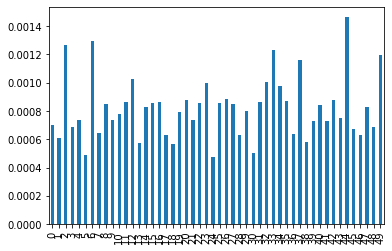

In [16]:
print("\nBest hyperparameters: ", grid_result_layers_full.best_params_)     
print("\nBest Score : %0.5f" % grid_result_layers_full.best_score_)
print(grid_result_layers_full.best_index_)
# scores of GridSearch CV
scores = pd.DataFrame(grid_result_layers_full.cv_results_)
pd.set_option('display.max_rows', None)
#scores

mean_sqr_scores = scores['mean_test_score'].apply(lambda x: -x)
mean_sqr_scores.plot.bar()
scores

In [18]:
# Time taken for random search CV in minutes.
(end_full - start_full)/60

143.32742476065954

## 4. Train an Auto-encoder with the best hyper-parameters

In [15]:
# keras.backend.clear_session()
tf.random.set_seed(42)

# Best hyperparameters:  {'learn_rate': 0.0211354, 'layer_sizes': (12, 6), 'gnoise': 0.15, 'batch_size': 128}

act_func = 'relu'
gnoise = 0.15
lr = 0.021
layer_sizes= (12,6)
momentum = 0.9
optim = keras.optimizers.Adam(learning_rate = lr, beta_1 = momentum)
num_epochs = 250
batch_size = 128


def create_model():
    flat = keras.layers.Flatten(input_shape=[train_df.shape[1]])
    gnl = keras.layers.GaussianNoise(gnoise)

    dense1 = keras.layers.Dense(layer_sizes[0], activation = act_func)
    dense2 = keras.layers.Dense(layer_sizes[1], activation = act_func)
    dense3 = keras.layers.Dense(layer_sizes[0], activation = act_func)
    dense4 = keras.layers.Dense(train_df.shape[1])

    encoder = keras.models.Sequential([flat, gnl, dense1, dense2])
    decoder = keras.models.Sequential([dense3, dense4])
    #decoder = keras.models.Sequential([dense4])

    autoencoder = keras.models.Sequential([encoder, decoder])
    return autoencoder

    #autoencoder.compile(loss = "mse", optimizer = optim)

#print(encoder.summary())
#print(decoder.summary())


#### Early stop the training if there is no improvement in val loss for 10 epochs.
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience= 10, \
                                               min_delta = 0.00001, verbose=1, \
                                               restore_best_weights = True)

autoencoder = create_model()  
autoencoder.compile(loss = "mse", optimizer = optim)

print(autoencoder.summary)


history = autoencoder.fit(train_df_scaled, train_df_scaled, epochs = num_epochs, \
                          validation_data = (val_df_scaled, val_df_scaled), \
                          callbacks = [early_stopping], batch_size = batch_size,
                          verbose = 1)

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000024B0865E208>>
Epoch 1/250
764/764 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 7.2188e-04
Epoch 2/250
764/764 [==============================] - 1s 1ms/step - loss: 8.8121e-04 - val_loss: 7.8749e-04
Epoch 3/250
764/764 [==============================] - 1s 1ms/step - loss: 8.7366e-04 - val_loss: 6.3592e-04
Epoch 4/250
764/764 [==============================] - 1s 1ms/step - loss: 8.7764e-04 - val_loss: 6.6223e-04
Epoch 5/250
764/764 [==============================] - 1s 1ms/step - loss: 8.7965e-04 - val_loss: 6.1996e-04
Epoch 6/250
764/764 [==============================] - 1s 1ms/step - loss: 8.7529e-04 - val_loss: 6.1734e-04
Epoch 7/250
764/764 [==============================] - 1s 1ms/step - loss: 8.5852e-04 - val_loss: 5.7012e-04
Epoch 8/250
764/764 [==============================] - 1s 1ms/step - loss: 8.4932e-04 - val_loss: 5.4697e-04
Epoch 9/250
76

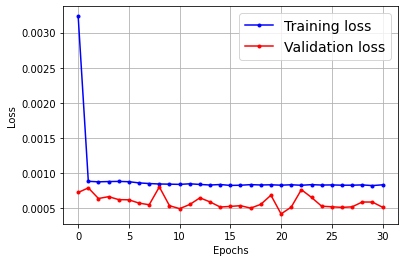

In [17]:
# Plot the progression of training data loss vs Validation data loss, across the epochs

plot_learning_curves(history.history["loss"], history.history["val_loss"])
#plt.yticks(np.arange(0.05, 0.1, 0.002))
plt.show()

In [20]:
# Save the model to local disk
autoencoder.save('ae_anomaly_detect_model')  # You can save as a .h5 file or a folder

# Load the saved model if needed
#from tensorflow.keras.models import load_model
#loaded_model = load_model('ae_anomaly_detect_model')

## 5.Evaluation of the Autoencoder model on the train, validation and good test data

### Predict and evaluate the reconstruction errors on training data

In [27]:
train_reconstructed_scaled = autoencoder.predict(train_df_scaled)
#train_reconstructed_scaled = loaded_model.predict(train_df_scaled)

# Scale back to original scale of 1-100 (as we trained the AE with scaled down inputs)
train_reconstructed = train_reconstructed_scaled * 100

train_row_loss, train_col_loss, train_mae_err_matrix = df_mae_loss_score(train_df, train_reconstructed)

##### Examine the distribution of the reconstruction error across training data rows 

count   97683.000
mean        1.324
std         0.199
min         0.684
25%         1.180
50%         1.325
75%         1.470
max         2.123
dtype: float64


C:\Users\rajar\anaconda3\envs\mlbook-rnn\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


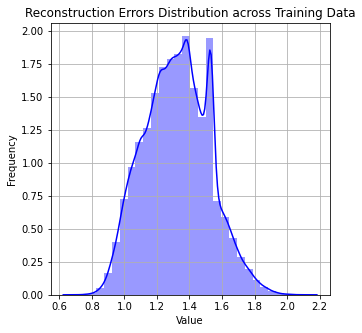

In [28]:
print(train_row_loss.describe())

plt.figure(figsize=(5, 5))  # Adjust the size as needed
sns.distplot(train_row_loss, bins=30, kde=True, color='blue')  # Set kde=True to overlay a KDE plot
plt.title('Reconstruction Errors Distribution across Training Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

We see that the AE reconstruction error distribution is close to a normal distribution with mean centered at around 1.32

In [29]:
# Feature wise error distribution of training data.
print(train_col_loss.describe())

count   25.000
mean     1.324
std      0.797
min      0.000
25%      0.970
50%      1.714
75%      1.901
max      2.108
dtype: float64


### Predict and evaluate the reconstruction errors on validation data

In [30]:
val_reconstructed_scaled = autoencoder.predict(val_df_scaled)

# Scale back to original scale of 1-100 (as we trained the AE with scaled down inputs)
val_reconstructed = val_reconstructed_scaled * 100

val_row_loss, val_col_loss, val_sqr_err_matrix = df_mae_loss_score(val_df, val_reconstructed)
print(val_row_loss.describe())
print()
print(val_col_loss.describe())

count   12301.000
mean        1.328
std         0.199
min         0.777
25%         1.179
50%         1.331
75%         1.473
max         2.014
dtype: float64

count   25.000
mean     1.328
std      0.803
min      0.000
25%      0.943
50%      1.722
75%      1.880
max      2.129
dtype: float64


The AE reconstruction error distribution of validation data is close to that of the training data.

### Predict and evaluate the reconstruction errors on the good test data

In [31]:
good_test_reconstructed_scaled = autoencoder.predict(good_test_df_scaled)

# Scale back to original scale of 1-100 (as we trained the AE with scaled down inputs)
good_test_reconstructed = good_test_reconstructed_scaled * 100

good_test_row_loss, good_test_col_loss, good_test_sqr_err_matrix = df_mae_loss_score(good_test_df, \
                                                                                     good_test_reconstructed)


In [32]:
print(good_test_row_loss.describe())

count   12227.000
mean        1.323
std         0.199
min         0.775
25%         1.179
50%         1.324
75%         1.465
max         2.061
dtype: float64


In [33]:
good_test_col_loss.describe()

count   25.000
mean     1.323
std      0.796
min      0.000
25%      0.986
50%      1.710
75%      1.890
max      2.112
dtype: float64

C:\Users\rajar\anaconda3\envs\mlbook-rnn\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


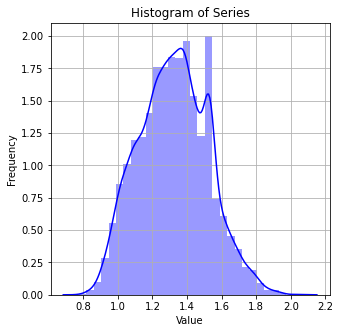

In [34]:
plt.figure(figsize=(5, 5))  # Adjust the size as needed
sns.distplot(good_test_row_loss, bins=30, kde=True, color='blue')  # Set kde=True to overlay a KDE plot
plt.title('Histogram of Series')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)

#### Box plot comparison of distributions of train record errors, good test record errors

Text(0.5, 1.0, 'Comparison - Spread of Reconstruction Errors')

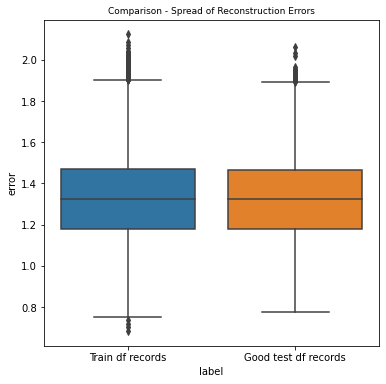

In [35]:
plt.figure(figsize=(6,6))
total_loss_df = pd.DataFrame()

box_plot_df1 = pd.DataFrame(train_row_loss)
box_plot_df1.columns = ['error']
box_plot_df1['label'] = 'Train df records'

box_plot_df2 = pd.DataFrame(good_test_row_loss)
box_plot_df2.columns = ['error']
box_plot_df2['label'] = 'Good test df records'

total_loss_df = pd.concat([total_loss_df, box_plot_df1, box_plot_df2], axis = 0)

sns.boxplot(x = 'label', y = 'error', data = total_loss_df).\
            axes.set_title('Comparison - Spread of Reconstruction Errors', fontsize = 9)


We see that the AE reconstruction error distribution of the test data is closely similar to that of the training data, with the mean error also almost the same as 1.32 

This proves that the AE model trained on the good training dataset, is able to generalize well (reduce and reconstruct well) on a similarly good test data. Here by "good", we mean dataset with good correlation among the features, without anomalies.


## 6. Detecting an anomaly in a bad test data

In [36]:
# Take a copy of the test data frame, to inject an anomalous value in it.
bad_test_df = good_test_df.copy().reset_index().drop('index', axis=1)
bad_test_df[0:10]

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25
0,13.000,10.000,51.000,52.000,55.000,49.000,13.000,47.000,58.000,89.000,...,39.000,68.000,79.000,31.000,41.513,35.128,70.000,31.000,42.660,36.000
1,13.000,10.000,51.000,52.000,55.000,51.995,13.000,49.446,58.000,89.000,...,39.000,68.000,79.000,31.000,50.000,45.000,70.000,31.000,50.000,36.000
2,13.000,10.000,61.000,60.270,64.283,59.000,13.000,57.000,59.322,89.000,...,39.000,68.000,79.000,31.000,50.000,45.000,70.000,31.000,50.000,36.000
3,13.000,10.000,51.000,52.000,55.000,49.000,13.000,48.464,58.000,89.000,...,39.000,68.000,79.000,31.000,41.279,45.000,70.000,31.000,47.461,36.000
4,13.000,10.000,55.109,54.686,55.000,49.000,13.000,47.889,58.000,89.000,...,39.000,68.000,79.000,31.000,40.000,45.000,70.000,31.000,50.000,36.000
5,13.000,10.000,61.000,62.000,63.368,59.000,13.000,57.000,65.880,89.000,...,39.000,72.059,79.000,31.000,50.000,45.000,70.000,31.000,50.000,36.000
6,13.000,10.000,51.000,52.000,55.000,49.000,13.000,47.000,58.000,89.000,...,29.000,68.000,79.000,21.000,40.000,35.000,70.000,21.000,40.000,26.000
7,13.000,10.000,51.000,52.000,55.000,49.000,13.000,47.000,58.000,89.000,...,34.015,68.000,79.000,31.000,41.002,35.000,70.000,31.000,40.000,36.000
8,13.000,10.000,61.000,62.000,65.000,59.000,13.000,57.000,65.086,89.000,...,39.000,68.000,79.000,31.000,50.000,45.000,78.073,31.000,50.000,36.000
9,13.000,10.000,61.000,62.000,65.000,59.000,13.000,57.000,58.620,89.000,...,39.000,68.000,79.000,31.000,50.000,45.000,70.000,31.000,50.000,36.000


### Inject an anomaly in the data

In [38]:
len(bad_test_df)

12227

In [37]:
# Skew the value of feature_4 (column 3) of the sixth row of the data set to an extremly high value - nearly 10X (anomaly)
bad_test_df.loc[6, 'Feature_4'] = 500

In [43]:
# Function to highlight a specific cell
def highlight_cell(x, row, col, color='orange'):
    # Create a DataFrame with empty values
    df_styler = pd.DataFrame('', index=x.index, columns=x.columns)
    # Highlight the specific cell
    df_styler.iloc[row, col] = f'background-color: {color}'
    return df_styler


# Apply the styling function (highlight cell at row 1, column 1)
bad_test_df[0:10].style.apply(highlight_cell, row=6, col=3, axis=None)

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25
0,13.000000,10.000000,51.000000,52.000000,55.000000,49.000000,13.000000,47.000000,58.000000,89.000000,35.000000,51.000000,43.000000,59.000000,83.000000,39.000000,68.000000,79.000000,31.000000,41.512821,35.128080,70.000000,31.000000,42.660007,36.000000
1,13.000000,10.000000,51.000000,52.000000,55.000000,51.994599,13.000000,49.446313,58.000000,89.000000,35.000000,56.800510,44.908460,59.000000,83.000000,39.000000,68.000000,79.000000,31.000000,50.000000,45.000000,70.000000,31.000000,50.000000,36.000000
2,13.000000,10.000000,61.000000,60.269962,64.283494,59.000000,13.000000,57.000000,59.321526,89.000000,35.000000,51.000000,53.000000,65.314001,83.000000,39.000000,68.000000,79.000000,31.000000,50.000000,45.000000,70.000000,31.000000,50.000000,36.000000
3,13.000000,10.000000,51.000000,52.000000,55.000000,49.000000,13.000000,48.463995,58.000000,89.000000,35.000000,51.000000,52.792486,59.000000,83.000000,39.000000,68.000000,79.000000,31.000000,41.278947,45.000000,70.000000,31.000000,47.461189,36.000000
4,13.000000,10.000000,55.108710,54.685896,55.000000,49.000000,13.000000,47.889390,58.000000,89.000000,35.000000,52.110627,53.000000,59.000000,83.000000,39.000000,68.000000,79.000000,31.000000,40.000000,45.000000,70.000000,31.000000,50.000000,36.000000
5,13.000000,10.000000,61.000000,62.000000,63.368419,59.000000,13.000000,57.000000,65.879572,89.000000,35.000000,61.000000,53.000000,69.000000,83.000000,39.000000,72.058675,79.000000,31.000000,50.000000,45.000000,70.000000,31.000000,50.000000,36.000000
6,13.000000,10.000000,51.000000,500.000000,55.000000,49.000000,13.000000,47.000000,58.000000,89.000000,25.000000,51.000000,43.000000,59.000000,83.000000,29.000000,68.000000,79.000000,21.000000,40.000000,35.000000,70.000000,21.000000,40.000000,26.000000
7,13.000000,10.000000,51.000000,52.000000,55.000000,49.000000,13.000000,47.000000,58.000000,89.000000,35.000000,51.000000,43.000000,59.000000,83.000000,34.015493,68.000000,79.000000,31.000000,41.001536,35.000000,70.000000,31.000000,40.000000,36.000000
8,13.000000,10.000000,61.000000,62.000000,65.000000,59.000000,13.000000,57.000000,65.086287,89.000000,35.000000,61.000000,53.000000,69.000000,83.000000,39.000000,68.000000,79.000000,31.000000,50.000000,45.000000,78.072904,31.000000,50.000000,36.000000
9,13.000000,10.000000,61.000000,62.000000,65.000000,59.000000,13.000000,57.000000,58.619529,89.000000,35.000000,61.000000,53.000000,64.209790,83.000000,39.000000,68.000000,79.000000,31.000000,50.000000,45.000000,70.000000,31.000000,50.000000,36.000000


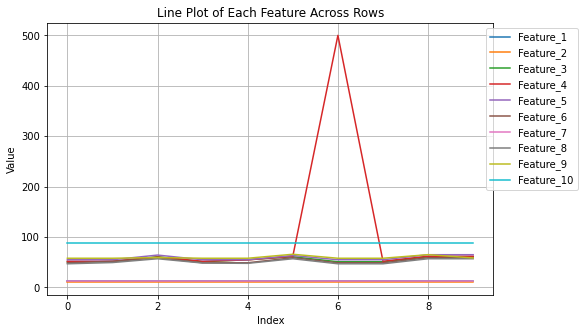

In [44]:
plt.figure(figsize=(8, 5))  # Adjust the figure size as needed

df_lim = bad_test_df.iloc[0:10, 0:10]
# Plot each feature in the DataFrame
for column in df_lim.columns:
    plt.plot(df_lim.index, df_lim[column], label=column)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot of Each Feature Across Rows')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))  # Adjust legend placement as needed
plt.grid(True)
plt.show()

### Predict and evaluate the reconstruction errors on the anomalous test data

In [45]:
# Pass the data set with the anomaly, to the AE model and get the reconstruction errors.

bad_test_df_scaled = bad_test_df/100

bad_test_reconstructed_scaled = autoencoder.predict(bad_test_df_scaled)

bad_test_reconstructed = bad_test_reconstructed_scaled * 100
bad_test_row_loss, bad_test_col_loss, bad_sqr_err_matrix = df_mae_loss_score(bad_test_df, bad_test_reconstructed)

In [46]:
bad_test_row_loss[0:10]

0    1.295
1    1.540
2    1.414
3    1.609
4    1.658
5    0.947
6   29.412
7    1.257
8    1.145
9    1.228
dtype: float64

In [47]:
print(bad_test_row_loss.describe())

count   12227.000
mean        1.325
std         0.323
min         0.775
25%         1.179
50%         1.324
75%         1.465
max        29.412
dtype: float64


In [48]:
bad_test_row_loss.idxmax()

6

We can observe that the reconstruction error of the row 6 is far high (maximum of all the errors) compared to the other rows, indicating that our AE model has not been able to reconstruct well, that particular row with the anomaly.
So we see that the row stands out as an anomaly in the reconstruction errors data too. **Thus AE has helped us identify that record.** 

##### Visualise and compare the reconstruction error distribution of training df, good test df and the bad test df.

Text(0.5, 1.0, 'Comparison - Spread of Reconstruction Errors')

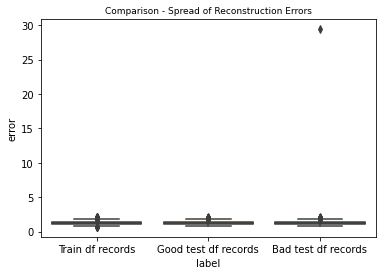

In [49]:
total_loss_df = pd.DataFrame()

box_plot_df1 = pd.DataFrame(train_row_loss)
box_plot_df1.columns = ['error']
box_plot_df1['label'] = 'Train df records'

box_plot_df2 = pd.DataFrame(good_test_row_loss)
box_plot_df2.columns = ['error']
box_plot_df2['label'] = 'Good test df records'

box_plot_df3 = pd.DataFrame(bad_test_row_loss)
box_plot_df3.columns = ['error']
box_plot_df3['label'] = 'Bad test df records'

total_loss_df = pd.concat([total_loss_df, box_plot_df1, box_plot_df2, box_plot_df3], axis = 0)

sns.boxplot(x = 'label', y = 'error', data = total_loss_df).\
            axes.set_title('Comparison - Spread of Reconstruction Errors', fontsize = 9)


We can see the bad anomalous record isolated at the top right of the above chart !

###### Now examine closely the original bad test df record, the corresponding reconstructed data and reconstruction errors by the AE model

In [50]:
# Original anomalous data - Record 6, Feature_4 is anomalous
bad_test_df.iloc[5:8]

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25
5,13.000,10.000,61.000,62.000,63.368,59.000,13.000,57.000,65.880,89.000,...,39.000,72.059,79.000,31.000,50.000,45.000,70.000,31.000,50.000,36.000
6,13.000,10.000,51.000,500.000,55.000,49.000,13.000,47.000,58.000,89.000,...,29.000,68.000,79.000,21.000,40.000,35.000,70.000,21.000,40.000,26.000
7,13.000,10.000,51.000,52.000,55.000,49.000,13.000,47.000,58.000,89.000,...,34.015,68.000,79.000,31.000,41.002,35.000,70.000,31.000,40.000,36.000


In [51]:
# Records reconstructed by the AE model for the above three original records. 
bad_test_reconstructed[5:8]

array([[13.   , 10.001, 58.502, 60.17 , 62.385, 57.624, 13.   , 55.167,
        64.596, 89.   , 35.277, 58.983, 51.98 , 65.209, 82.999, 39.318,
        70.541, 79.   , 31.183, 48.941, 44.46 , 72.049, 31.171, 49.272,
        36.196],
       [14.379,  9.932, 75.589, 78.832, 80.248, 74.42 , 12.952, 68.969,
        81.878, 90.556, 35.425, 77.912, 63.103, 81.584, 83.035, 39.777,
        81.351, 81.384, 29.751, 55.685, 47.552, 80.577, 31.074, 55.726,
        36.041],
       [13.   , 10.   , 51.701, 53.216, 55.972, 50.647, 13.   , 48.164,
        58.94 , 89.   , 31.826, 52.345, 44.939, 59.948, 83.   , 35.125,
        67.796, 79.   , 28.744, 42.582, 38.916, 70.064, 28.731, 42.748,
        32.776]], dtype=float32)

In [52]:
# Corresponding reconstruction errors across the features, for the three records 
bad_sqr_err_matrix[5:8]

array([[  0.   ,   0.001,   2.498,   1.83 ,   0.983,   1.376,   0.   ,
          1.833,   1.283,   0.   ,   0.277,   2.017,   1.02 ,   3.791,
          0.001,   0.318,   1.517,   0.   ,   0.183,   1.059,   0.54 ,
          2.049,   0.171,   0.728,   0.196],
       [  1.379,   0.068,  24.589, 421.168,  25.248,  25.42 ,   0.048,
         21.969,  23.878,   1.556,  10.425,  26.912,  20.103,  22.584,
          0.035,  10.777,  13.351,   2.384,   8.751,  15.685,  12.552,
         10.577,  10.074,  15.726,  10.041],
       [  0.   ,   0.   ,   0.701,   1.216,   0.972,   1.647,   0.   ,
          1.164,   0.94 ,   0.   ,   3.174,   1.345,   1.939,   0.948,
          0.   ,   1.109,   0.204,   0.   ,   2.256,   1.58 ,   3.916,
          0.064,   2.269,   2.748,   3.224]])

We can clearly observe only the **record 6 ( second row in above ) has high reconstruction errors** for the feature values.

#### Can we also find the exact feature in that record which is anomaly ? Let's find out !
###### Now we will try to see which feature/column shows up the highest error in that record

In [53]:
# Show the column index with the maximum error in the record 6
pd.Series(bad_sqr_err_matrix[6]).idxmax()

3

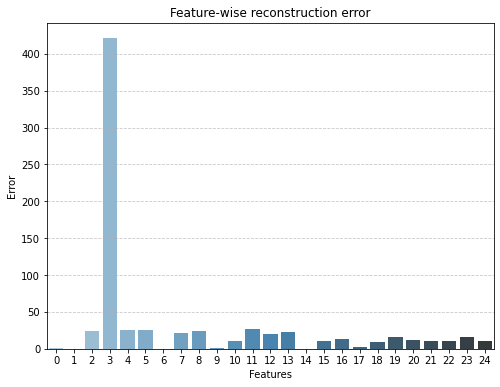

In [54]:
data = pd.DataFrame(bad_sqr_err_matrix[6], index = list(range(0, 25)))
col_err_df = data.reset_index()
col_err_df.columns = ['Features', 'Error']

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.barplot(x='Features', y='Error', data=col_err_df, palette='Blues_d')
plt.title('Feature-wise reconstruction error')
plt.xlabel('Features')
plt.ylabel('Error')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.show()


Vow !! We can see above that **the column 3 (Feature_4 which was anomaly) shows the highest error** in that record. <br>

##### So, AE has also helped us find out the exact feature in that record which is anomaly !!

In [55]:
# Print the pairs of the feature value, corresponding reconstruction error in the record 6.
list(zip(bad_test_df.iloc[6].round(3), bad_sqr_err_matrix[6].round(3)))

[(13.0, 1.379),
 (10.0, 0.068),
 (51.0, 24.589),
 (500.0, 421.168),
 (55.0, 25.248),
 (49.0, 25.42),
 (13.0, 0.048),
 (47.0, 21.969),
 (58.0, 23.878),
 (89.0, 1.556),
 (25.0, 10.425),
 (51.0, 26.912),
 (43.0, 20.103),
 (59.0, 22.584),
 (83.0, 0.035),
 (29.0, 10.777),
 (68.0, 13.351),
 (79.0, 2.384),
 (21.0, 8.751),
 (40.0, 15.685),
 (35.0, 12.552),
 (70.0, 10.577),
 (21.0, 10.074),
 (40.0, 15.726),
 (26.0, 10.041)]

#### So, we are able to use the AE model to isolate and detect the anomaly in the dataset along with the information on the specific record and the feature.